In [ ]:
# default_exp surfaces

In [ ]:
#hide_input
from pivotpy.utils import nav_links 
nav_links(4)

<style>a{text-decoration: none !important;color:lightkblue;font-weight:bold;}
                a:focus,a:active,a:hover{color:hotpink !important;}</style>
> [&nbsp;`▶` Index&nbsp;](https://massgh.github.io/pivotpy/)  
> [&nbsp;`▶` Example&nbsp;](https://massgh.github.io/pivotpy/Example)  
> [&nbsp;`▶` StaticPlots&nbsp;](https://massgh.github.io/pivotpy/StaticPlots)  
> [&nbsp;`▶` InteractivePlots&nbsp;](https://massgh.github.io/pivotpy/InteractivePlots)  
> [&nbsp;`▶` SpinProjectedSurfaces●&nbsp;](https://massgh.github.io/pivotpy/SpinProjectedSurfaces)  
> [&nbsp;`▶` StructureIO&nbsp;](https://massgh.github.io/pivotpy/StructureIO)  
> [&nbsp;`▶` Widgets&nbsp;](https://massgh.github.io/pivotpy/Widgets)  
> [&nbsp;`▶` MainAPI&nbsp;](https://massgh.github.io/pivotpy/MainAPI)  


# Fermi Surfaces and Spin Texture
This module plots 2D and 3D fermi surfaces and spin textures.

In [ ]:
#export
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
# Inside packages import to work both with package and jupyter notebook.
try:
    from pivotpy import parser as vp
    from pivotpy import api, serializer, splots
    from pivotpy.splots import _validate_input
except:
    import pivotpy.parser as vp
    import pivotpy.api as api
    import pivotpy.serializer as serializer
    import pivotpy.splots as splots
    import pivotpy.splots._validate_input as _validate_input

In [ ]:

#export
def _collect_spin_data(exported_spin_data, band = 0, elements = [[0],], orbs = [[0],], scale_data = False, E_Fermi = None):
    if not isinstance(band,int):
        raise TypeError('`band` must be an integer.')
    elements, orbs, _ = _validate_input(elements,orbs,[str(i) for i,o in enumerate(orbs)],sys_info = exported_spin_data.sys_info, rgb = False)

    fermi = E_Fermi or exported_spin_data.evals.E_Fermi

    kpoints = exported_spin_data.kpoints
    evals = {k: v[:,band] for k,v in exported_spin_data.evals.items() if k in 'eud'}
    spins = {k: v[:,:,band,:] for k,v in exported_spin_data.spins.items() if k in 'sxyzud'}

    df_dict = {f'k{k}':v for k,v in zip('xyz',kpoints.T)}

    for k,v in evals.items():
        df_dict[k if k=='e' else f'e{k}'] = v.T.flatten() - fermi

    for i, (e, o) in enumerate(zip(elements,orbs)):
        for k,v in spins.items():
            if k in 'sxyzud':
                key = k if k == 's' else f's{k}'
                df_dict[f'{key}_{i}'] = v.take(e,axis=0).take(o,axis=2).sum(axis=2).sum(axis=0).T.flatten()

    if scale_data == True:
        _max = []
        for k,v in df_dict.items():
            if k.startswith('s'):
                _max.append(np.abs(v).max())

        _max = max(_max)
        for k,v in df_dict.items():
            if k.startswith('s'):
                df_dict[k] = v / (_max if _max != 0 else 1)
    return df_dict

class SpinDataFrame(pd.DataFrame):
    """Spin data from vasprun.xml is converted to a dataframe.
    - **Parameters**:
        - path: path to `vasprun.xml` or auto picks in current directory.
        - band: band index to plot, only one band is supported.
        - elements: list of elements to plot. inner list contains ions indices.
        - orbs: list of orbitals to plot. inner list contains orbitals indices.
        - scale_data: if True, data is scaled to -1 to 1.
        - E_Fermi: if not None, auto picked as Fermi level from vasprun.xml.
        - skipk: if not None, auto skipped unnecessary k-points.
        - elim: if not None, filtered out unnecessary bands.
        - data: if not None, data is loaded from given data/pickle/json/dict and validated. Many other parameters are ignored when data is given.

    - **Returns**:
        - SpinDataFrame: dataframe with colums as k-points, eigenvalues, spin components projected over selected ions and orbtials.

    - **Methods**:
        - sliced: Slice data in a plane orthogonal to given `column` at given `value`.
        - masked: Mask data over a constant value in a given column. Useful for plotting fermi level/surface.
        - splot: plot data in a 2D plot.

        All other methods are inherited from pd.DataFrame. If you apply some method, then use `wraps` to wrap the result in a SpinDataFrame.
    """
    _metadata = ['cmap','scale_data','sys_info','poscar'] # These are passed after operations to new dataframe.
    def __init__(self, *args, path = None, band = 0, elements = [[0],], orbs = [[0],], scale_data = False, E_Fermi = None, elim = None, skipk=None, data = None, **kwargs):
        if not (path or args): # It works fine without path given, but it is not recommended.
            path = './vasprun.xml'
        if path or data: # Don't updates args otherwise
            spin_data = None # To avoid access before assignment
            if data:
                spin_data = serializer.SpinData.validated(data)
            elif isinstance(path, str):
                try: # Check if 4 sets of data are there.
                    spin_data = vp.export_spin_data(path, spins = 'sxyz',skipk = skipk, elim = elim)
                except: # If not 4 sets
                    spin_data = vp.export_spin_data(path, spins = 's',skipk = skipk, elim = elim)
            else:
                raise ValueError('Invalid path or data!')
            
            if spin_data:
                out_dict = _collect_spin_data(spin_data, band = band, elements = elements, orbs = orbs, scale_data = scale_data, E_Fermi = E_Fermi)
                super().__init__(out_dict)
                self.cmap = 'viridis'
                self.scale_data = scale_data
                self.sys_info = spin_data.sys_info
                # Path below is used to get kpoints info
                self.poscar = api.POSCAR(path = path, data = spin_data.poscar)
                self.poscar._kpts_info = spin_data.sys_info.kpts_info
        else: # This part is only for operations on dataframe.
            if len(args) == 1: # This gives hack to load data from a file in current directory.
                if (args[0] is None) or isinstance(args[0],str): # If path is given as positional argument
                    raise ValueError('SpinDataFrame expects no positional argument!')
            super().__init__(*args, **kwargs)
        
    @property
    def _constructor(self):
        "That's main hero of this class. This is called when you apply some method of slice it."
        return SpinDataFrame

    def masked(self, column, value, tol = 1e-2, n = None, method = 'cubic'):
        """Mask dataframe with a given value, using a tolerance.
        If n is given, data values are interpolated to grid of size (l,m,n) where n is longest side.
        n could be arbirarily large as mask will filter out data outside the tolerance."""
        if n and not isinstance(n,int):
            raise TypeError('`n` must be an integer to be applied to short side of grid.')

        df = self.copy() # To avoid changing original dataframe
        df.drop(df.index, inplace=True)  # only columns names there and metadata
    
        kxyz = self[['kx','ky','kz']].to_numpy()
        lx,*_,hx = self['kx'].sort_values(inplace=False)
        ly,*_,hy = self['ky'].sort_values(inplace=False)
        lz,*_,hz = self['kz'].sort_values(inplace=False)
        vs = np.array([hx-lx,hy-ly, hz-lz])
        nx, ny, nz = nxyz = (vs/vs.max()*n).astype(int)
        nijk = [i for i,n in enumerate(nxyz) if n > 0]

        if len(nijk) < 2:
            raise ValueError('At least two of kx,ky,kz must have non-coplanar points.')
        
        if len(nijk) == 3:
            xyz = kxyz.T
            XYZ = [a.flatten() for a in np.mgrid[lx:hx:nx*1j,ly:hy:ny*1j,lz:hz:nz*1j]]
            for name, index in zip('xyz',range(3)):
                df[f'k{name}'] = XYZ[index]
        else:
            [l1,l2],[h1,h2],[n1,n2] = np.array([[lx,ly,lz],[hx,hy,hz],[nx,ny,nz]])[:,nijk]
            xyz = kxyz.T[nijk]
            XYZ = [a.flatten() for a in np.mgrid[l1:h1:n1*1j,l2:h2:n2*1j]]
            for name, index in zip('xyz',range(3)):
                if index in nijk:
                    df[f'k{name}'] = XYZ[index]
                else:
                    df[f'k{name}'] = np.zeros_like(XYZ[0])

        for c in [_c for _c in self.columns if _c not in 'kxkykz']:
            df[c] = griddata(tuple(xyz),self[c].to_numpy(),tuple(XYZ),method = method)

        df = df.round(6).dropna()

        if self.scale_data == True:
            _max = []
            for k in [c for c in df.columns if c.startswith('s')]:
                _max.append(np.abs(df[k]).max())

            _max = max(_max)
            for k in [c for c in df.columns if c.startswith('s')]:
                df[k] = df[k] / (_max if _max != 0 else 1)
        
        # Make sure to keep metadata, it doesn't work otherwise.
        for k in self._metadata:
            setattr(df, k, getattr(self, k)) 

        return df[np.logical_and((df[column] < value + tol),(df[column] > value-tol))]

    def sliced(self,column = 'kz', value = 0):
        "Slice data in a plane orthogonal to given `column` at given `value`"
        return self[self[column] == value]

    def splot(self,*args, arrows = [], every=4, norm = 1, marker='H', ax = None, quiver_kws = {}, scale = None, **kwargs):
        """Plot energy in 2D with/without arrows.
        - **Parameters**:
            - *args: 3 or 4 names of columns, representing X,Y,Energy, and optionally, something to colorize data. if kwargs has color, that takes precedence.
            - arrows: 2 or 3 names of columns, representing U,V as arrows direstcion, and optionally, something to colorize data.
            - every: every nth point is plotted as arrow.
            - norm: normalization factor for size of arrows.
            - marker: marker to use for scatter, use s as another argument to change size.
            - ax: matplotlib axes to plot on (defaults to auto create one).
            - quiver_kws: these are passed to matplotlib.pyplot.quiver.
            - scale: scale factor for if kpoints in cartesian mode. This should be closer to `2π/a`, where `a` is on second line of POSCAR.
        **kwargs are passed to matplotlib.pyplot.scatter.

        - **Returns**:
            - ax: matplotlib axes. It has additinal method `colorbar` to plot colorbar from most recent plot.

        See examples at https://massgh.github.io/pivotpy/
        """
        if arrows and len(arrows) not in [2,3]:
            raise ValueError('`arrows ` requires 2 or 3 items form spin data [s1,s2,[color]], one of s1,s2 could be "".')
        if len(args) not in [3,4]:
            raise ValueError('splot takes 3 or 4 positional arguments [X,Y,E,[color]]')

        for arg in args:
            if arg not in self.columns:
                raise ValueError(f'{arg!r} is not a column in the dataframe')

        arrows_data = []
        for i, arr in enumerate(arrows):
            if arr not in ['',*self.columns]:
                raise ValueError(f'{arr!r} is not a column in the dataframe')
            arrows_data.append(self[arr] if arr else np.zeros_like(self['kx'].to_numpy()))

        arrows_data = np.array(arrows_data).T

        kij = [['kx','ky','kz'].index(a) for a in args[:2]]
        kxyz = self[['kx','ky','kz']].to_numpy()
        kxyz = self.poscar.bring_in_bz(kxyz, scale = scale)

        ax = ax or api.get_axes()
        minmax_c = [0,1]
        self.cmap = kwargs.get('cmap',self.cmap)

        if arrows:
            self.cmap = quiver_kws.get('cmap',self.cmap)
            ax.quiver(*kxyz[::every].T[kij],*(norm*arrows_data[::every].T), **quiver_kws)
            if len(arrows) == 3:
                minmax_c = [arrows_data[:,2].min(),arrows_data[:,2].max()]
        else:
            _C = self[args[3]] if len(args) == 4 else self[args[2]]
            kwargs['marker'] = marker # Avoid double marker
            if 'color' in kwargs:
                kwargs['c'] = kwargs['color']
                del kwargs['color'] # keep one

            kwargs['c'] = kwargs.get('c',_C)
            ax.scatter(*kxyz.T[kij],**kwargs)
            minmax_c = [min(_C),max(_C)]

        def colorbar(cax = None, nticks = 6, **kwargs):
            "kwargs are passed to pivotpy.splots.add_colorbar"
            ticks = np.linspace(0,1,nticks, endpoint=True)
            labels = np.linspace(*minmax_c,nticks,endpoint=True).round(2).astype(str)
            return ax.add_colorbar(cax, self.cmap ,ticks = list(ticks), ticklabels=labels, **kwargs)

        ax.colobar = colorbar
        return ax
    
    def splot3d(self,*args, arrows = [], every=4,norm = 1, marker='H', ax = None, quiver_kws = {'arrowstyle':'-|>','size':1}, scale = None, **kwargs):
        """Plot energy in 3D with/without arrows.
        - **Parameters**:
            - *args: 4 or 5 names of columns, representing X,Y,Z,Energy, and optionally, something to colorize data. if kwargs has color, that takes precedence.
            - arrows: 3 or 4 names of columns, representing U,V,W as arrows direstcion, and optionally, something to colorize data.
            - every: every nth point is plotted as arrow.
            - norm: normalization factor for size of arrows.
            - marker: marker to use for scatter, use s as another argument to change size.
            - ax: matplotlib 3d axes to plot on (defaults to auto create one).
            - quiver_kws: these are passed to pivotpy.fancy_quiver3d.
            - scale: scale factor for if kpoints in cartesian mode. This should be closer to `2π/a`, where `a` is on second line of POSCAR.
        **kwargs are passed to matplotlib.pyplot.scatter.

        - **Returns**:
            - ax: matplotlib 3d axes. It has additinal method `colorbar` to plot colorbar from most recent plot.

        See examples at https://massgh.github.io/pivotpy/
        """
        if arrows and len(arrows) not in [3,4]:
            raise ValueError('`arrows ` requires 3 or 4 items form spin data [s1,s2, s2, [color]], one of s1,s2,s3 could be "".')
        if len(args) not in [4,5]:
            raise ValueError('splot takes 4 or 5 positional arguments [X,Y,Z,E,[color]]')

        for arg in args:
            if arg not in self.columns:
                raise ValueError(f'{arg!r} is not a column in the dataframe')

        arrows_data = []
        for i, arr in enumerate(arrows):
            if arr not in ['',*self.columns]:
                raise ValueError(f'{arr!r} is not a column in the dataframe')
            arrows_data.append(self[arr] if arr else np.zeros_like(self['kx'].to_numpy()))

        arrows_data = np.array(arrows_data).T

        kij = [['kx','ky','kz'].index(a) for a in args[:3]]
        kxyz = self[['kx','ky','kz']].to_numpy()
        kxyz = self.poscar.bring_in_bz(kxyz, scale = scale)

        ax = ax or api.get_axes(axes_3d=True)
        minmax_c = [0,1]
        self.cmap = kwargs.get('cmap',self.cmap)

        if arrows:
            self.cmap = quiver_kws.get('cmap',self.cmap)
            if len(arrows) == 4:
                array = arrows_data[::every,3]
                array = (array - array.min())/np.ptp(array)
                quiver_kws['C'] = plt.get_cmap(self.cmap)(array)
                minmax_c = [arrows_data[:,3].min(),arrows_data[:,3].max()]
            elif 'color' in quiver_kws:
                quiver_kws['C'] = quiver_kws['color']
                quiver_kws.pop('color') # It is not in FancyArrowPatch
            elif len(arrows) == 3:
                array = np.linalg.norm(arrows_data[::every,:3],axis=1)
                minmax_c = [array.min(),array.max()] # Fist set then normalize
                array = (array - array.min())/np.ptp(array)
                quiver_kws['C'] = plt.get_cmap(self.cmap)(array)
                
            if 'cmap' in quiver_kws:
                quiver_kws.pop('cmap') # It is not in fancy_quiver3d
            
            
            api.fancy_quiver3d(*kxyz[::every].T[kij],*(norm*arrows_data[::every].T[:3]), **quiver_kws,ax=ax)
                
        else:
            _C = self[args[4]] if len(args) == 5 else self[args[3]]
            kwargs['marker'] = marker # Avoid double marker
            if 'color' in kwargs:
                kwargs['c'] = kwargs['color']
                del kwargs['color'] # keep one

            kwargs['c'] = kwargs.get('c',_C)
            ax.scatter(*kxyz.T[kij],**kwargs)
            minmax_c = [min(_C),max(_C)]

        def colorbar(cax = None, nticks = 6, **kwargs):
            "kwargs are passed to pivotpy.splots.add_colorbar"
            cax = cax or plt.gcf().add_axes([0.85, 0.15, 0.03, 0.7])
            ticks = np.linspace(0,1,nticks, endpoint=True)
            labels = np.linspace(*minmax_c,nticks,endpoint=True).round(2).astype(str)
            return splots.add_colorbar(cax, cax, self.cmap ,ticks = list(ticks), ticklabels=labels, **kwargs)

        ax.colobar = colorbar
        return ax

# Examples
Data is not complete though :-)

In [ ]:
df = SpinDataFrame(path = r'E:\Research\graphene_example\ISPIN_2\dos\sigm0_01\vasprun.xml',
                   band=3,elements=[[0],[1]], orbs= [(0,1),(1,2,3)],scale_data=True)

 Found ISPIN = 2, output data got attributes spins.<u,d> instead of spins.<s,x,y,z>


Text(0, 0.5, '$S_\\uparrow(C_1-p)$')

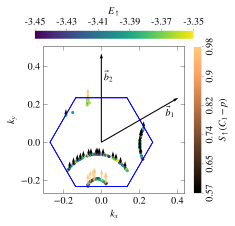

In [ ]:
(ax1,_),(ax2,ax3) = api.get_axes((3,3),ncols=2,nrows=2,widths=[20,1],heights=[1,18],axes_off=[(0,1)],hspace=0.1,wspace=0.0)
df2 = df.masked('eu',-3.4,0.05,n=100,method='linear')
df2.splot('kx','ky','eu',s=5,ax=ax2)
ax2.colobar(ax1,vertical=False)
df2.splot('kx','ky','eu','su_1',arrows=['','su_1','su_1'],quiver_kws= dict(cmap='copper'),ax=ax2)
cax2 = ax2.colobar(ax3)
df2.poscar.splot_bz(plane='xy',ax=ax2)
ax1.xaxis.set_label_position("top")
ax1.set_xlabel('$E_\\uparrow $')
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('$S_\\uparrow(C_1-p)$')

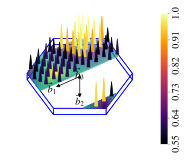

In [ ]:
df['kz'] = 0
ax = df.splot3d('kx','ky','kz','eu',s=3)
df.splot3d('kx','ky','kz','eu',arrows=['','','su_1'],norm=0.2,every=15,quiver_kws= dict(arrowstyle='wedge',cmap='inferno',zorder=3),ax=ax)
df.poscar.splot_bz(ax=ax,fill=False)
ax.view_init(elev=50,azim=90)
ax.colobar()
ax.set_axis_off()

## Plotting with any library
You can plot using methods of your choices from your favorite libraries, to collect data for that purpose, see example below.

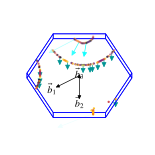

In [ ]:
ax3d = api.get_axes(axes_3d=True)
KPTS = df2.poscar.bring_in_bz(df2[['kx','ky','kz']].to_numpy())
KPTS[:,2] = 0
ax3d.scatter(*KPTS.T,c = df2['eu'],s=2,cmap='inferno')
df2.poscar.splot_bz(ax=ax3d,fill=False)

UVW = df2[['su_0','sd_1','su_1']].to_numpy()
api.fancy_quiver3d(*KPTS[::8].T,*UVW[::8].T/5,C = np.abs(UVW)[::8]/UVW.max(),arrowstyle='-|>',ax=ax3d)
ax3d.set_axis_off()
ax3d.view_init(elev=60,azim=90)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_scatter3d(x = KPTS[:,0],y = KPTS[:,1], z = KPTS[:,2],marker =dict(color= np.abs(UVW)/UVW.max(),size=2),mode='markers')
df2.poscar.iplot_bz(fig=fig)
fig.add_cone(x = KPTS[::8,0],y = KPTS[::8,1], z = KPTS[::8,2],u = UVW[::8,0],v = UVW[::8,1], w = UVW[::8,2],sizemode='absolute',sizeref=50,colorscale='magma',showscale=False)
api.iplot2html(fig, modebar= False)